In [5]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os, shutil

from scipy.ndimage import gaussian_filter, uniform_filter

In [9]:
dir_low = 'datasets/data_original/CFRP_60_low/'
dir_high = 'datasets/data_original/CFRP_60_high/'
in_size = (40, 128)
out_size = (80, 256)

Original image size (WxH): (382, 288)
Brightest point found at (x, y): (195, 152)
Calculated crop box (left, upper, right, lower): (np.int64(175), np.int64(88), np.int64(215), np.int64(216))


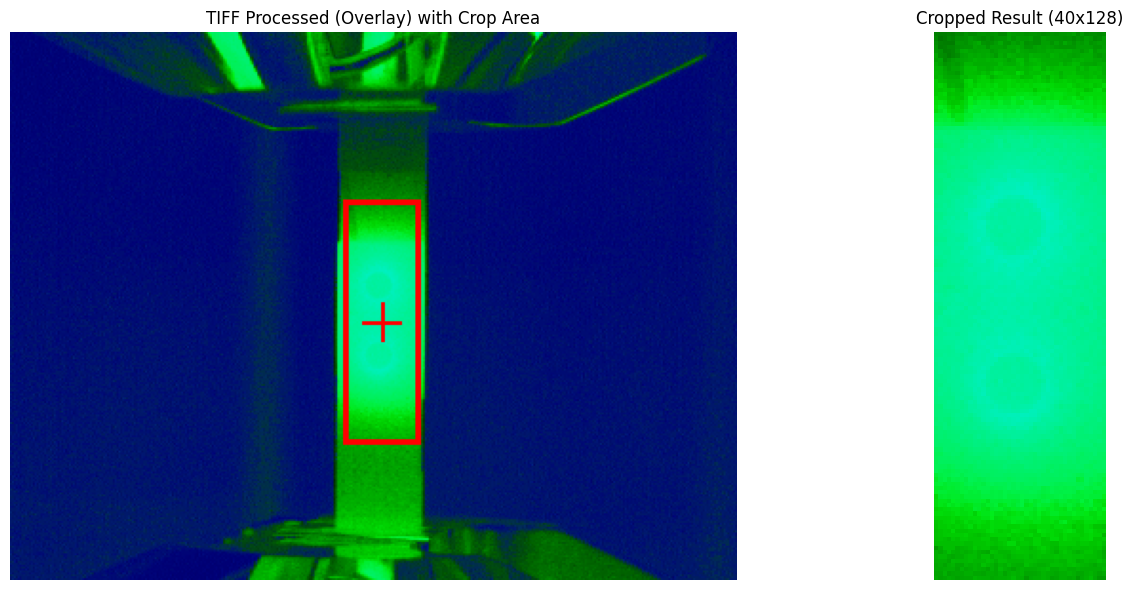

Original image size (WxH): (174, 512)
Brightest point found at (x, y): (67, 278)
Calculated crop box (left, upper, right, lower): (np.int64(27), np.int64(150), np.int64(107), np.int64(406))


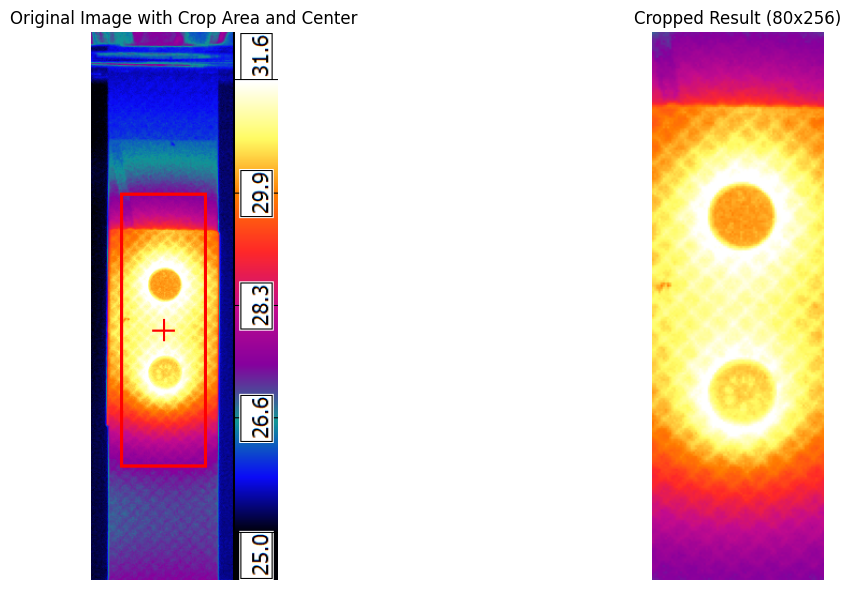

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageChops
from scipy.ndimage import gaussian_filter

def crop_to_brightest_plot(image_path: str, crop_size: tuple[int, int], tiff=False):
    try:
        # Open raw image
        raw_image = Image.open(image_path)
        
        # If tiff format (Overlay p1 * p2)
        if tiff:
            try:
                raw_image.seek(0)
                p1 = raw_image.copy().convert("RGB")
                
                raw_image.seek(1)
                p2 = raw_image.copy().convert("RGB")
                
                original_image = ImageChops.multiply(p1, p2)
            except EOFError:
                print("Error : Tiff format does not contain enough frames.")
                return
        else:
            # Otherwise, keep the image
            original_image = raw_image

    except FileNotFoundError:
        print(f"Error: The file '{image_path}' was not found.")
        return
    except Exception as e:
        print(f"Error opening or reading the image: {e}")
        return

    # --- Le reste du code s'applique maintenant sur 'original_image' (traitée ou non) ---

    if original_image.mode not in ['I', 'F', 'L']:
        # 'L' converts to 8-bit grayscale
        grayscale_image = original_image.convert('L') 
    else:
        grayscale_image = original_image

    image_array = np.array(grayscale_image)
    
    # Gestion des images entièrement noires ou vides pour éviter les erreurs
    if image_array.max() == image_array.min():
        print("Warning: L'image est uniforme (probablement noire). Impossible de trouver un point brillant.")
        return

    window_size = 150
    filtered_image = gaussian_filter(image_array.astype(np.float32), sigma=window_size/6)

    # Find the coordinates of the maximum value in the filtered image.
    max_loc = np.unravel_index(np.argmax(filtered_image), filtered_image.shape)
    center_y, center_x = max_loc

    print(f"Original image size (WxH): {original_image.size}")
    print(f"Brightest point found at (x, y): ({center_x}, {center_y})")
    
    crop_width, crop_height = crop_size

    left = center_x - crop_width // 2
    upper = center_y - crop_height // 2
    right = left + crop_width
    lower = upper + crop_height

    # Ensure crop is within bounds
    left = max(0, left)
    upper = max(0, upper)
    right = min(original_image.width, right)
    lower = min(original_image.height, lower)

    crop_box = (left, upper, right, lower)
    print(f"Calculated crop box (left, upper, right, lower): {crop_box}")

    cropped_image = original_image.crop(crop_box)
    
    # Préparation pour la visualisation
    viz_image = original_image.convert("RGB")
    draw = ImageDraw.Draw(viz_image)
    draw.rectangle(crop_box, outline="red", width=3)

    cross_size = 10
    draw.line((center_x - cross_size, center_y, center_x + cross_size, center_y), fill="red", width=2)
    draw.line((center_x, center_y - cross_size, center_x, center_y + cross_size), fill="red", width=2)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].imshow(viz_image)
    if tiff:
        axes[0].set_title("TIFF Processed (Overlay) with Crop Area")
    else:
        axes[0].set_title("Original Image with Crop Area and Center")
    axes[0].axis('off')
    
    cmap = 'gray' if cropped_image.mode != 'RGB' else None
    axes[1].imshow(cropped_image, cmap=cmap)
    axes[1].set_title(f"Cropped Result ({cropped_image.width}x{cropped_image.height})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
crop_to_brightest_plot("datasets/data_original/CFRP_60_low/Record_2025-11-11_10-42-17.tiff", in_size, tiff=True)
crop_to_brightest_plot("datasets/data_original/CFRP_60_high/prst_A_stat_03_5_230149.png", out_size, tiff=False)
# Exemples d'utilisation (assurez-vous que vos variables in_size/out_size et paths sont définis)
# in_size = (512, 512)
# crop_to_brightest_plot("chemin/vers/image.tiff", in_size, tiff=True)

In [7]:
def crop_relevant_zone(image_path: str, crop_size: tuple[int, int], tiff=False):
    try:
        raw_image = Image.open(image_path)
        
        # Apply specific processing if tiff is True
        if tiff:
            try:
                raw_image.seek(0)
                p1 = raw_image.copy().convert("L")
                
                raw_image.seek(1)
                p2 = raw_image.copy().convert("L")
                
                # The image to work on becomes the product of the two frames
                original_image = ImageChops.multiply(p1, p2)
            except EOFError:
                print(f"Error: The TIFF file '{image_path}' does not contain enough frames.")
                return None
        else:
            # Otherwise use the image as is
            original_image = raw_image

    except FileNotFoundError:
        print(f"Error: The file '{image_path}' was not found.")
        return None
    except Exception as e:
        print(f"Error opening or reading the image: {e}")
        return None

    if original_image.mode not in ['I', 'F', 'L']:
        grayscale_image = original_image.convert('L') # 'L' converts to 8-bit grayscale
    else:
        grayscale_image = original_image

    image_array = np.array(grayscale_image)
    
    # Safety check to avoid errors on empty/black images
    if image_array.size == 0 or image_array.max() == image_array.min():
         return None

    window_size = 150
    filtered_image = gaussian_filter(image_array.astype(np.float32), sigma= window_size/6)

    max_loc = np.unravel_index(np.argmax(filtered_image), filtered_image.shape)
    center_y, center_x = max_loc

    crop_width, crop_height = crop_size

    left = center_x - crop_width // 2
    upper = center_y - crop_height // 2
    right = left + crop_width
    lower = upper + crop_height

    left = max(0, left)
    upper = max(0, upper)
    right = min(original_image.width, right)
    lower = min(original_image.height, lower)

    crop_box = (left, upper, right, lower)
    cropped_image = original_image.crop(crop_box)
    return cropped_image

# --- Usage Examples ---

in_size = (40, 120)
out_size = (80, 240)

# Note: tiff=True added for the .tiff file
crop_relevant_zone(os.path.join(dir_low, "Record_2025-11-11_10-42-17.tiff"), in_size, tiff=True)
crop_relevant_zone(os.path.join(dir_high, "prst_A_stat_03_5_230149.png"), out_size)

def flip(image: Image.Image, horizontal: bool = False, vertical: bool = False) -> Image.Image:
    if horizontal:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if vertical:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    return image

In [14]:
def main(average=False):
    flip_possible = [(False, False), (True, False), (False, True), (True, True)]

    # Create output directory / reset it 
    if not os.path.exists(dir_result):
        os.makedirs(dir_result)
    else : 
        shutil.rmtree(dir_result)
        os.makedirs(dir_result)
    
    os.makedirs(os.path.join(dir_result,'low'))
    os.makedirs(os.path.join(dir_result,'high'))

    if not average :
        print('Processing without averaging...')

        # Process low-resolution images
        print("--- Processing low-resolution images ---")
        image_count = 0
        # Note: Le calcul de number_of_images est approximatif ici (dépend du filtre) mais utile pour la barre de progression
        tiff_files = [name for name in os.listdir(dir_low) if name.endswith('.tiff')]
        number_of_images = len(tiff_files) * 4 
        
        for filename in tiff_files:
            inputh_path = os.path.join(dir_low, filename)
            # On garde tiff=True ici pour l'overlay
            cropped_image = crop_relevant_zone(inputh_path, in_size, tiff=True)
            
            if cropped_image is not None:
                for h_flip, v_flip in flip_possible:
                    augmented_image = flip(cropped_image, horizontal=h_flip, vertical=v_flip)
                    output_path = os.path.join(dir_result, 'low', f"{image_count}.png")
                    augmented_image.save(output_path)
                    image_count += 1
                    print(f"Processed and saved image: {image_count}/{number_of_images}", end='\r')
        print("") # Retour à la ligne après la boucle
        
        # Process high-resolution images
        print("--- Processing high-resolution images ---")
        image_count = 0
        png_files = [name for name in os.listdir(dir_high) if name.endswith('.png')]
        number_of_images = len(png_files) * 4
        
        for filename in png_files:
            inputh_path = os.path.join(dir_high, filename)
            cropped_image = crop_relevant_zone(inputh_path, out_size)
            
            if cropped_image is not None:
                for h_flip, v_flip in flip_possible:
                    augmented_image = flip(cropped_image, horizontal=h_flip, vertical=v_flip)
                    output_path = os.path.join(dir_result, 'high', f"{image_count}.png")
                    augmented_image.save(output_path)
                    image_count += 1
                    print(f"Processed and saved image: {image_count}/{number_of_images}", end='\r')
        print("")

    else :
        print('Processing with averaging...')

        # Process low-resolution images
        print("--- Processing low-resolution images ---")
        image_count = 0
        tiff_files = [name for name in os.listdir(dir_low) if name.endswith('.tiff')]
        number_of_images = len(tiff_files) * 4 * (len(tiff_files)-1)
        
        for filename1 in tiff_files:
            for filename2 in tiff_files:
                if filename1 != filename2:
                    inputh_path1 = os.path.join(dir_low, filename1)
                    cropped_image1 = crop_relevant_zone(inputh_path1, in_size, tiff=True)
                    
                    inputh_path2 = os.path.join(dir_low, filename2)
                    cropped_image2 = crop_relevant_zone(inputh_path2, in_size, tiff=True)
                    
                    if cropped_image1 is not None and cropped_image2 is not None:
                        average_image = Image.blend(cropped_image1, cropped_image2, alpha=0.5)

                        for h_flip, v_flip in flip_possible:
                            augmented_image = flip(average_image, horizontal=h_flip, vertical=v_flip)
                            output_path = os.path.join(dir_result, 'low', f"{image_count}.png")
                            augmented_image.save(output_path)
                            image_count += 1
                            print(f"Processed and saved image: {image_count}/{number_of_images}", end='\r')
        print("")

        # Process high-resolution images
        print("--- Processing high-resolution images ---")
        image_count = 0
        png_files = [name for name in os.listdir(dir_high) if name.endswith('.png')]
        # Note: Le calcul number_of_images ici est indicatif
        
        for filename1 in png_files:
            for filename2 in png_files:
                if filename1 != filename2:
                    inputh_path1 = os.path.join(dir_high, filename1)
                    # Correction: in_size -> out_size
                    cropped_image1 = crop_relevant_zone(inputh_path1, out_size)
                    
                    inputh_path2 = os.path.join(dir_high, filename2)
                    # Correction: in_size -> out_size
                    cropped_image2 = crop_relevant_zone(inputh_path2, out_size)
                    
                    if cropped_image1 is not None and cropped_image2 is not None:
                        average_image = Image.blend(cropped_image1, cropped_image2, alpha=0.5)

                        for h_flip, v_flip in flip_possible:
                            augmented_image = flip(average_image, horizontal=h_flip, vertical=v_flip)
                            output_path = os.path.join(dir_result, 'high', f"{image_count}.png")
                            augmented_image.save(output_path)
                            image_count += 1
                            print(f"Processed and saved image: {image_count}", end='\r')
        print("")

if __name__ == "__main__" : 
    main(average=False)

Processing without averaging...
--- Processing low-resolution images ---
Processed and saved image: 200/200
--- Processing high-resolution images ---
Processed and saved image: 200/200
